
---

### Homework #2 

**Names:**

- Erica Drummond
- Madison Meyers
- Jake Miller
- Shrinath Parikh
- Pranati Yadlapalli  

*NEUR 3002 - Due 1/26/2024*

---

#### Question 1

##### **Leaky Integrate and Fire Code Explanation**

The code sets parameters such as the resting potential and threshold potential as well as a refractory period between spikes. Then it runs a simulation over 100 ms with a constant 100 $\mu A$ current. This resulted in steady firing of the LIF neuron as seen the generated plot. The plot also draws the spikes as thin "event" lines once the potential reaches threshold.


---

#### Questions 2 and 3
##### **Leaky Integrate and Fire Code**

*From ChatGPT with modifications*

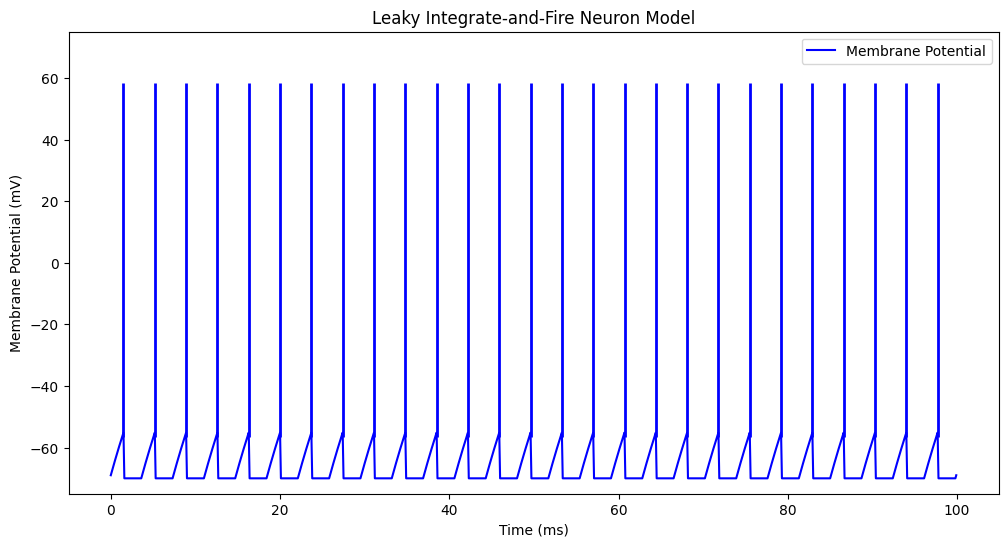

In [40]:
import numpy as np
import matplotlib.pyplot as plt

class LIFNeuron:
    def __init__(self, tau_m=10, v_rest=-70, v_thresh=-55, tau_ref=2):
        self.tau_m = tau_m  # membrane time constant
        self.v_rest = v_rest  # resting membrane potential
        self.v_thresh = v_thresh  # threshold potential
        self.tau_ref = tau_ref  # refractory period
        self.reset()

    def reset(self):
        self.v = self.v_rest
        self.refractory_time = 0

    def update(self, dt, current):
        if self.refractory_time > 0:
            self.refractory_time -= dt
            self.v = self.v_rest
        else:
            dv = (-(self.v - self.v_rest) + current) / self.tau_m * dt
            self.v += dv
            if self.v >= self.v_thresh:
                self.v = self.v_rest
                self.refractory_time = self.tau_ref
                return True  # Spike occurred
        return False

def simulate_lif_neuron(neuron, currents, dt=0.1, duration=100):
    
    num_steps = int(duration / dt)

    voltages = []
    spike_times = []

    for i in range(num_steps):
        current = currents[i] if i < len(currents) else 0
        spike_occurred = neuron.update(dt, current)
        voltages.append(neuron.v)

        if spike_occurred:
            spike_times.append(i * dt)

    time = np.arange(0, duration, dt)
    return time, voltages, spike_times

# Example usage:
currents = np.ones(1000)*100  # 100 ms of input current
neuron = LIFNeuron()
time, voltages, spike_times = simulate_lif_neuron(neuron, currents)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.plot(time, voltages, label='Membrane Potential',color='b')
plt.eventplot(np.array(spike_times)-0.1, color='b', linewidths=2, linelengths=115) # Draw the spikes

plt.title('Leaky Integrate-and-Fire Neuron Model')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.ylim([-75, 75])
plt.legend()

plt.show()



---

#### Question 4

The LIF model does not do great at mimicking actual action potentials. The spike's are modeled as single time step ticks rather than having a depolarization and repolarization phase. Also, this model just inputs one generic current rather than taking into account many complex temporally or spatially summed inputs from presynaptic neurons. Biological neurons have other properties like plasticity which require more sophisticated models than the LIF to replicate. It only considers sodium and potassium channels as well when many other ions can play an important role in the spiking like calcium for instance. More complex modelling of the leak instead of a single resistor could also have an impact on variables like the time constant, effeting the firing.


---

#### Question 5

The most challenging aspect of this homework was producing a good model of an LIF neuron, especially when primarily using ChatGPT to generate the code. Getting more specific features or values directly out of ChatGPT was difficult, so there was extra work involved in parsing its code to modify it and improve our model. Essentially, it was easy to get a decent start from ChatGPT, but the real labor was in dissecting its code for improvements.


---
#### Question 6

This homework took 1.5 hours to complete.